Downloading the necessary modules and libraries for the project.

In [1]:
# Using these lines in terminal and remember to set the environment variable to this ipynb file
# conda create --name comp.sgn.120 python=3.11.3
# conda activate comp.sgn.120
# conda install numpy=1.26.2
# pip install ipykernel --upgrade
# conda install -c conda-forge ffmpeg

# Uncomment these lines to run and install the required packages if you haven't already
# !pip install pydub==0.25.1
# !pip install tqdm==4.66.1
# !pip install librosa==0.10.1
# !pip install matplotlib==3.7.2
# !pip install scikit-learn==1.3.2
# !pip install scipy==1.11.4 
# !pip install pandas==2.1.4


Necessary Modules and Libraries

In [2]:
import os

# Database loading and Feature extraction
# from pydub import AudioSegment
import librosa as lb
import librosa.display
from scipy.stats import skew, kurtosis
from scipy.signal import hamming, hann


# Representation
import matplotlib.pyplot as plt

# Data processing
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_pandas

tqdm.pandas()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Training
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib.colors import ListedColormap

Function for reading the data

In [3]:
def readFolder(folder):
    folder_names = []
    for root, dirs, files in os.walk(folder):
        for name in dirs:
            folder_names.append(os.path.join(root, name))
    return folder_names


def readFileInFolder(folder):
    file_lists = []
    for root, dirs, files in os.walk(folder):
        for name in files:
            file_lists.append(os.path.join(root, name))
    return file_lists

Function for extracting the features

In [4]:
def no_spectrogram_feature(data, ft1):
    ft2 = librosa.feature.zero_crossing_rate(y=data)[0]
    ft3 = librosa.feature.spectral_rolloff(y=data)[0]
    ft4 = librosa.feature.spectral_centroid(y=data)[0]
    ft5 = librosa.feature.spectral_contrast(y=data)[0]
    ft6 = librosa.feature.spectral_bandwidth(y=data)[0]

    ft1_trunc = np.hstack(
        (
            np.mean(ft1),
            np.std(ft1),
            skew(ft1),
            np.max(ft1),
            np.median(ft1),
            np.min(ft1),
        )
    )
    ft2_trunc = np.hstack(
        (
            np.mean(ft2),
            np.std(ft2),
            skew(ft2),
            np.max(ft2),
            np.median(ft2),
            np.min(ft2),
        )
    )
    ft3_trunc = np.hstack(
        (
            np.mean(ft3),
            np.std(ft3),
            skew(ft3),
            np.max(ft3),
            np.median(ft3),
            np.min(ft3),
        )
    )
    ft4_trunc = np.hstack(
        (
            np.mean(ft4),
            np.std(ft4),
            skew(ft4),
            np.max(ft4),
            np.median(ft4),
            np.min(ft4),
        )
    )
    ft5_trunc = np.hstack(
        (
            np.mean(ft5),
            np.std(ft5),
            skew(ft5),
            np.max(ft5),
            np.median(ft5),
            np.min(ft5),
        )
    )
    ft6_trunc = np.hstack(
        (
            np.mean(ft6),
            np.std(ft6),
            skew(ft6),
            np.max(ft6),
            np.median(ft6),
            np.max(ft6),
        )
    )
    return (ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)


def spectrogram_feature(data, ft1):
    ft2 = librosa.feature.zero_crossing_rate(y=data)[0]
    ft3 = librosa.feature.spectral_rolloff(y=data)[0]
    ft4 = librosa.feature.spectral_centroid(y=data)[0]
    ft5 = librosa.feature.spectral_contrast(y=data)[0]
    ft6 = librosa.feature.spectral_bandwidth(y=data)[0]

    ft1_trunc = np.hstack(
        (
            np.mean(ft1),
            np.std(ft1),
            np.max(ft1),
            np.median(ft1),
            np.min(ft1),
        )
    )
    ft2_trunc = np.hstack(
        (
            np.mean(ft2),
            np.std(ft2),
            np.max(ft2),
            np.median(ft2),
            np.min(ft2),
        )
    )
    ft3_trunc = np.hstack(
        (
            np.mean(ft3),
            np.std(ft3),
            np.max(ft3),
            np.median(ft3),
            np.min(ft3),
        )
    )
    ft4_trunc = np.hstack(
        (
            np.mean(ft4),
            np.std(ft4),
            np.max(ft4),
            np.median(ft4),
            np.min(ft4),
        )
    )
    ft5_trunc = np.hstack(
        (
            np.mean(ft5),
            np.std(ft5),
            np.max(ft5),
            np.median(ft5),
            np.min(ft5),
        )
    )
    ft6_trunc = np.hstack(
        (
            np.mean(ft6),
            np.std(ft6),
            np.max(ft6),
            np.median(ft6),
            np.max(ft6),
        )
    )
    return (ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)


def getEnergy(name, path=None):
    data, _ = librosa.core.load(name, sr=None)
    frame_size = 512
    hop_size = 128
    energy_features = []
    
    # Segmenting the audio file into frames to extract features more precisely
    for i in range(0, len(data), hop_size):
        frame = data[i : i + frame_size]
        energy_features.append(np.sum(np.power(frame, 2)))
    energy_features = np.array(energy_features)

    (
        ft1_trunc,
        ft2_trunc,
        ft3_trunc,
        ft4_trunc,
        ft5_trunc,
        ft6_trunc,
    ) = no_spectrogram_feature(data, energy_features)
    return pd.Series(
        np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))
    )


def getRMS(name, path=None):
    data, _ = librosa.core.load(name, sr=None)
    frame_size = 512
    hop_size = 128
    rms_features = []
    
    # Segmenting the audio file into frames to extract features more precisely
    for i in range(0, len(data), hop_size):
        frame = data[i : i + frame_size]
        rms_features.append(np.sqrt(np.mean(np.power(frame, 2))))
    rms_features = np.array(rms_features)
    (
        ft1_trunc,
        ft2_trunc,
        ft3_trunc,
        ft4_trunc,
        ft5_trunc,
        ft6_trunc,
    ) = no_spectrogram_feature(data, rms_features)
    return pd.Series(
        np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))
    )


def getSpec(name, path=None):
    n_fft = 512
    hop_size = 128
    data, _ = librosa.core.load(name, sr=None)
    spectrogram = lb.amplitude_to_db(
        np.abs(lb.stft(data, n_fft=n_fft, hop_length=hop_size))
    )
    (
        ft1_trunc,
        ft2_trunc,
        ft3_trunc,
        ft4_trunc,
        ft5_trunc,
        ft6_trunc,
    ) = spectrogram_feature(data, spectrogram)
    return pd.Series(
        np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))
    )


def getMel(name, path=None):
    n_mel = 40
    hop_size = 128
    n_fft = 512
    frame_size = 512
    data, _ = librosa.core.load(name, sr=None)
    spec = np.abs(lb.stft(data, n_fft=n_fft, hop_length=hop_size))
    mel = lb.feature.melspectrogram(S=spec, n_mels=n_mel)
    (
        ft1_trunc,
        ft2_trunc,
        ft3_trunc,
        ft4_trunc,
        ft5_trunc,
        ft6_trunc,
    ) = spectrogram_feature(data, mel)
    return pd.Series(
        np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))
    )


def getLogMel(name, path=None):
    n_mel = 40
    hop_size = 128
    n_fft = 512
    data, _ = librosa.core.load(name, sr=22050)
    spec = np.abs(lb.stft(data, n_fft=n_fft, hop_length=hop_size))
    mel = lb.feature.melspectrogram(S=spec, n_mels=n_mel)
    logmel = lb.power_to_db(mel)
    (
        ft1_trunc,
        ft2_trunc,
        ft3_trunc,
        ft4_trunc,
        ft5_trunc,
        ft6_trunc,
    ) = spectrogram_feature(data, logmel)
    return pd.Series(
        np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))
    )


def getMFCC(name, path):
    n_mel = 40
    hop_size = 128
    n_fft = 512
    data, _ = librosa.core.load(name, sr=None)

    try:
        ft1 = lb.feature.mfcc(
            y=data, n_mfcc=n_mel, hop_length=hop_size, norm="ortho", n_fft=n_fft
        )
        (
            ft1_trunc,
            ft2_trunc,
            ft3_trunc,
            ft4_trunc,
            ft5_trunc,
            ft6_trunc,
        ) = spectrogram_feature(data, ft1)
        return pd.Series(
            np.hstack(
                (ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)
            )
        )
    except:
        print("bad file")

        return pd.Series([0] * 210)


def getCQT(name, path=None):
    n_mel = 40
    hop_size = 128
    n_fft = 512
    data, _ = librosa.core.load(name, sr=22050)
    cqt = lb.amplitude_to_db(np.abs(lb.cqt(data, sr=22050, hop_length=hop_size)))
    (
        ft1_trunc,
        ft2_trunc,
        ft3_trunc,
        ft4_trunc,
        ft5_trunc,
        ft6_trunc,
    ) = spectrogram_feature(data, cqt)
    return pd.Series(
        np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))
    )

Evaluating function

In [5]:
def printAccuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average = 'macro')
    
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return accuracy, precision, recall

Data preprocessing

In [6]:
# Tram_Train: https://freesound.org/people/publictransport/packs/36726/
# Tram_Train: https://freesound.org/people/ali.abdelsalam/packs/36722/
# Bus_Train: https://freesound.org/people/emmakyllikki/packs/36810/
# Bus_Train: https://freesound.org/people/glingden/packs/36807/
# Tram_Test: My own recording
# Bus_Test: My own recording
folder_list = readFolder("audio")
folder_to_read = ["Bus_Test", "Bus_Train", "Tram_Test", "Tram_Train"]
bus_test = []
bus_train = []
tram_test = []
tram_train = []
label = {}
for folder in folder_list:
    # Read all the files and append to the list of files
    files = readFileInFolder(folder)
    for name in folder_to_read:
        if name in folder:
            # Append the files to the corresponding list
            if name == "Bus_Test":
                bus_test = files
                for file in files:
                    label[file] = "bus"
            elif name == "Bus_Train":
                bus_train = files
                for file in files:
                    label[file] = "bus"
            elif name == "Tram_Test":
                tram_test = files
                for file in files:
                    label[file] = "tram"
            elif name == "Tram_Train":
                tram_train = files
                for file in files:
                    label[file] = "tram"

In [7]:
# Prepare Data
train_data = pd.DataFrame()
train_data["fname"] = bus_train + tram_train
test_data = pd.DataFrame()
test_data["fname"] = bus_test + tram_test

train_data = train_data["fname"].progress_apply(getMFCC, path = None)
print("done loading train mfcc")
test_data = test_data["fname"].progress_apply(getMFCC, path = None)
print("done loading test mfcc")


100%|██████████| 98/98 [00:22<00:00,  4.27it/s]


done loading train mfcc


100%|██████████| 18/18 [00:06<00:00,  2.70it/s]

done loading test mfcc


In [8]:
train_data["fname"] = bus_train + tram_train
train_data["label"] = train_data["fname"].apply(lambda x: label[x])
test_data["fname"] = bus_test + tram_test
test_data["label"] = test_data["fname"].apply(lambda x: label[x])

In [9]:
def getDataset(train_data, test_data):
    X = train_data.drop(['label', 'fname'], axis=1)
    feature_names = list(X.columns)
    X = X.values

    labels = np.sort(np.unique(train_data.label.values))

    num_class = len(labels)
    c2i = {}
    i2c = {}
    for i, c in enumerate(labels):
        c2i[c] = i
        i2c[i] = c
    y = np.array([c2i[x] for x in train_data.label.values])
    X_test = test_data.drop(['label', 'fname'], axis=1).values
    y_test = np.array([c2i[x] for x in test_data.label.values])

    return (X, y, X_test, y_test, feature_names, num_class, c2i, i2c)

In [10]:
X, y, X_test, y_test, feature_names, num_class, c2i, i2c = getDataset(
    train_data, test_data)

In [11]:
# A function that exporting the csv file from the beginning of the
def exportCSV(y_pred, y_test, filename, bus_test=bus_test, tram_test=tram_test, i2c=i2c):
    # convert the binary data into a class label (bus or tram)
    y_pred_label = []
    for i in range(len(y_pred)):
        y_pred_label.append(i2c[y_pred[i]])
    y_pred_label = np.array(y_pred_label)


    # convert the binary data into a class label (bus or tram)
    y_test_label = []
    for i in range(len(y_test)):
        y_test_label.append(i2c[y_test[i]])
    y_test_label = np.array(y_test_label)

    y_test_name = []
    for i in range(len(bus_test)):
        y_test_name.append(os.path.basename(bus_test[i]))
    for i in range(len(tram_test)):
        y_test_name.append(os.path.basename(tram_test[i]))
    y_test_name = np.array(y_test_name)


    # Export the CSV file using y_test_name, y_pred_label, and y_test_label
    df = pd.DataFrame(
        {'fname': y_test_name, 'y_pred': y_pred_label, 'y_test': y_test_label})
    df.to_csv(filename, index=False)

In [12]:
def dataPreprocessing(X, X_test):
    # Apply scaling for PCA
    scaler = StandardScaler()
    scaler.fit_transform(X)
    X_scaled = scaler.transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA for dimension reduction (if the model is too slow to train, reduce the number of components)
    # try:
    #     pca = PCA(n_components=65).fit(X_scaled)
    #     X_pca = pca.transform(X_scaled)
    #     X_test_pca = pca.transform(X_test_scaled)
    #     print(sum(pca.explained_variance_ratio_))
    # except:
    #     pca = PCA(n_components=30).fit(X_scaled)
    #     X_pca = pca.transform(X_scaled)
    #     X_test_pca = pca.transform(X_test_scaled)
    #     print(sum(pca.explained_variance_ratio_))
    pca = PCA(n_components=2).fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(sum(pca.explained_variance_ratio_))
    # X_pca = X_scaled
    # X_test_pca = X_test_scaled
    return X_scaled, X_test_scaled, X_pca, X_test_pca

In [13]:
def plot_decision_boundary(X, y, model, title):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    h = .02  # step size in the mesh
    # Calculate min, max and limits
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict class using model and data
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()


In [14]:
def dataProcessAndTrainAndEvaluate(X_pca, y, feature="MFCC"):
    # Build a KNN model
    X_train, X_val, y_train, y_val = train_test_split(
        X_pca, y, test_size=0.01, random_state=42, shuffle=True)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    # Test the kNN model with the test data
    y_pred = knn.predict(X_test_pca)
    print("KNN: ")
    printAccuracy(y_test, y_pred)
    exportCSV(y_pred, y_test, f'{feature}_KNN_output.csv')

    # Build a SVM model
    X_train, X_val, y_train, y_val = train_test_split(
        X_pca, y, test_size=0.01, random_state=42, shuffle=True)
    clf = SVC(kernel='rbf', probability=True)
    clf.fit(X_train, y_train)

    # Test the SVM model with the test data
    y_pred = clf.predict(X_test_pca)
    print("SVM: ")
    printAccuracy(y_test, y_pred)
    print(f"Decision Boundary for kNN classfiier with {feature} features, k=5")
    plot_decision_boundary(X_train, y_train, knn, "KNN decision boundary")
    print(f"Decision Boundary for SVM classfiier with {feature} features")
    plot_decision_boundary(X_train, y_train, clf, "SVM decision boundary")
    exportCSV(y_pred, y_test, f'{feature}_SVM_output.csv')

0.5945425964362843
KNN: 
Accuracy:  0.9444444444444444
Precision:  0.9545454545454546
Recall:  0.9375
SVM: 
Accuracy:  0.8888888888888888
Precision:  0.9166666666666667
Recall:  0.875
Decision Boundary for kNN classfiier with MFCC features, k=5


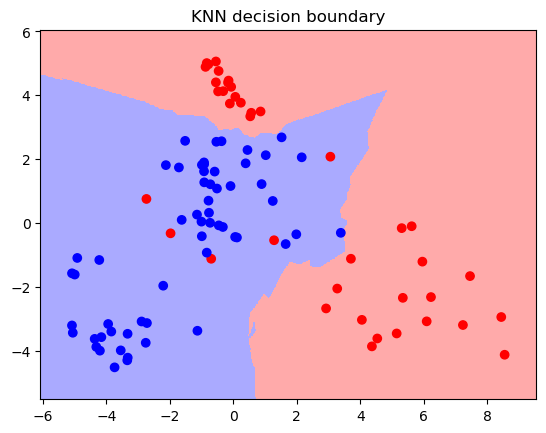

Decision Boundary for SVM classfiier with MFCC features


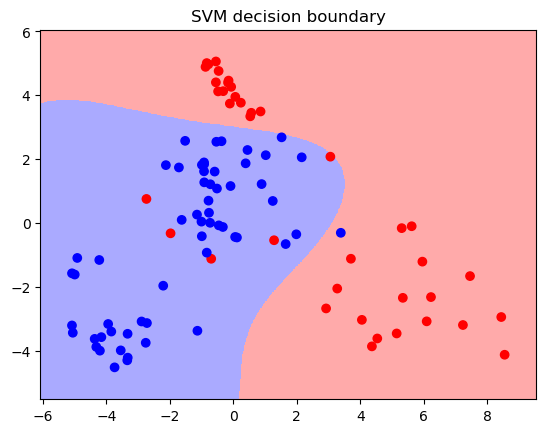

In [15]:
X_scaled, X_test_scaled, X_pca, X_test_pca = dataPreprocessing(X, X_test)
dataProcessAndTrainAndEvaluate(X_pca, y)

In [16]:
# Continuing with other features
train_data_list = []
test_data_list = []
feature_names_list = ["energy", "rms", "spec", "mel", "logmel", "cqt"]
feature_functions = [getEnergy, getRMS, getSpec, getMel, getLogMel, getCQT]
for i in range(len(feature_functions)):
    train_data = pd.DataFrame()
    train_data["fname"] = bus_train + tram_train
    test_data = pd.DataFrame()
    test_data["fname"] = bus_test + tram_test

    train_data = train_data["fname"].progress_apply(
        feature_functions[i], path=None)
    print("done loading train", feature_names_list[i])
    test_data = test_data["fname"].progress_apply(
        feature_functions[i], path=None)
    print("done loading test", feature_names_list[i])

    train_data["fname"] = bus_train + tram_train
    train_data["label"] = train_data["fname"].apply(lambda x: label[x])
    test_data["fname"] = bus_test + tram_test
    test_data["label"] = test_data["fname"].apply(lambda x: label[x])

    train_data_list.append(train_data)
    test_data_list.append(test_data)

100%|██████████| 98/98 [00:22<00:00,  4.27it/s]


done loading train energy


100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


done loading test energy


100%|██████████| 98/98 [00:29<00:00,  3.28it/s]


done loading train rms


100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


done loading test rms


100%|██████████| 98/98 [00:23<00:00,  4.15it/s]


done loading train spec


100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


done loading test spec


100%|██████████| 98/98 [00:22<00:00,  4.35it/s]


done loading train mel


100%|██████████| 18/18 [00:06<00:00,  2.88it/s]


done loading test mel


100%|██████████| 98/98 [00:12<00:00,  8.06it/s]


done loading train logmel


100%|██████████| 18/18 [00:03<00:00,  4.90it/s]


done loading test logmel


100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


done loading train cqt


100%|██████████| 18/18 [00:05<00:00,  3.17it/s]

done loading test cqt


Feature: energy
0.5800022020646739
KNN: 
Accuracy:  0.6666666666666666
Precision:  0.7857142857142857
Recall:  0.7
SVM: 
Accuracy:  0.6666666666666666
Precision:  0.7857142857142857
Recall:  0.7
Decision Boundary for kNN classfiier with energy features, k=5


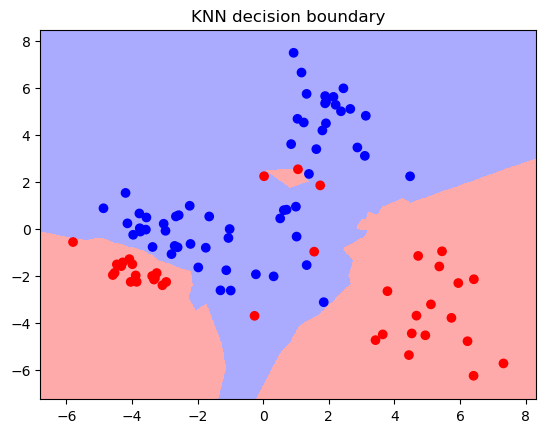

Decision Boundary for SVM classfiier with energy features


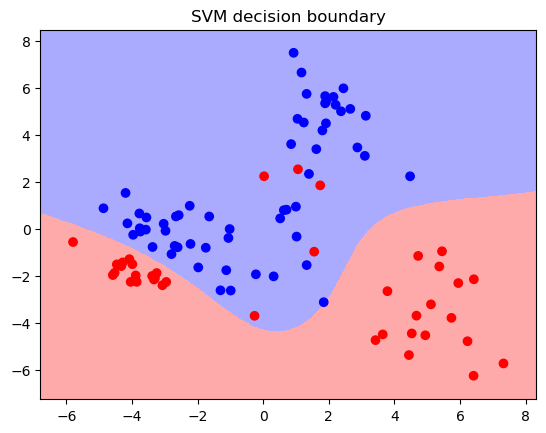


Feature: rms
0.5864776323324902
KNN: 
Accuracy:  0.6666666666666666
Precision:  0.7857142857142857
Recall:  0.7
SVM: 
Accuracy:  0.6666666666666666
Precision:  0.7857142857142857
Recall:  0.7
Decision Boundary for kNN classfiier with rms features, k=5


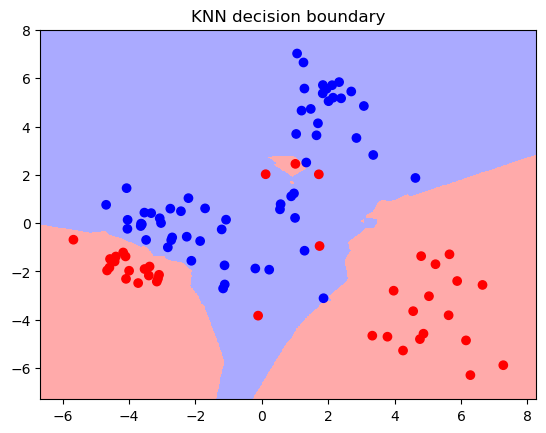

Decision Boundary for SVM classfiier with rms features


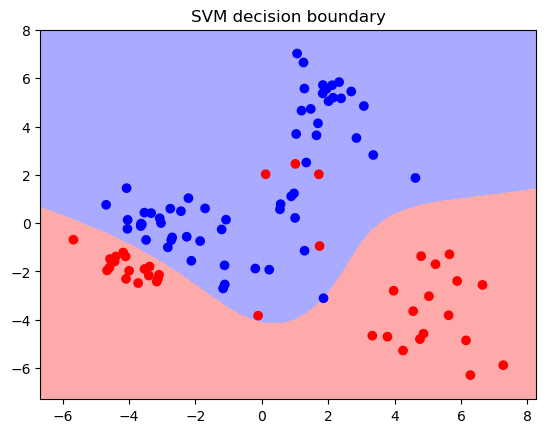


Feature: spec
0.5665661624004011
KNN: 
Accuracy:  0.6111111111111112
Precision:  0.6692307692307693
Recall:  0.6375
SVM: 
Accuracy:  0.6666666666666666
Precision:  0.7083333333333334
Recall:  0.6875
Decision Boundary for kNN classfiier with spec features, k=5


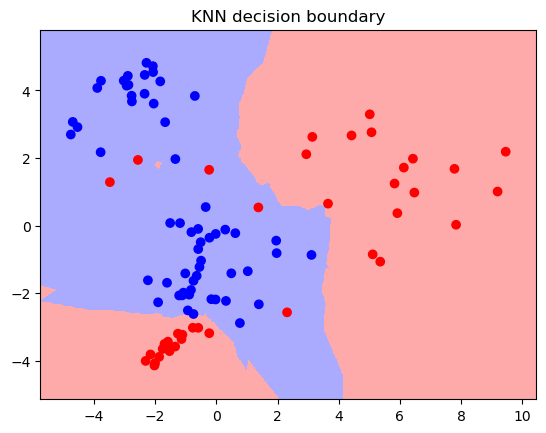

Decision Boundary for SVM classfiier with spec features


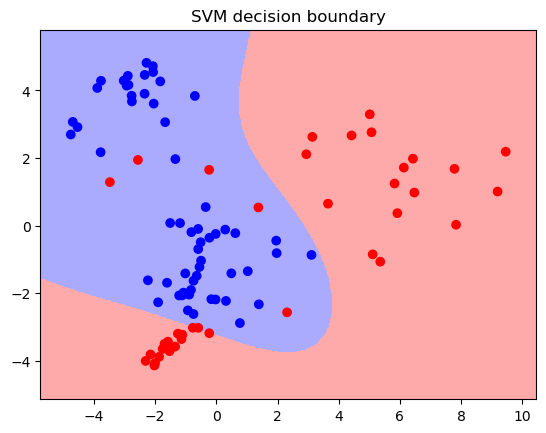


Feature: mel
0.5647717944739095
KNN: 
Accuracy:  0.6666666666666666
Precision:  0.7857142857142857
Recall:  0.7
SVM: 
Accuracy:  0.5555555555555556
Precision:  0.5833333333333333
Recall:  0.575
Decision Boundary for kNN classfiier with mel features, k=5


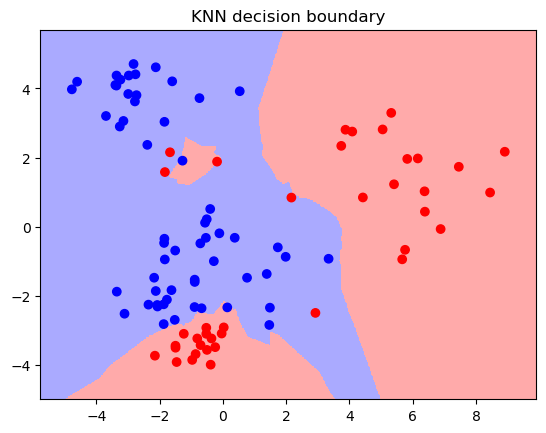

Decision Boundary for SVM classfiier with mel features


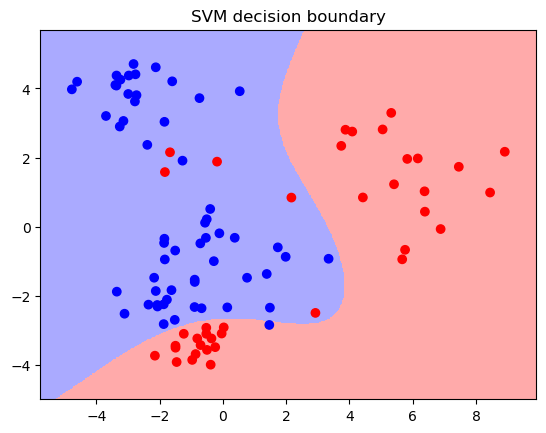


Feature: logmel
0.5256775065267434
KNN: 
Accuracy:  0.2777777777777778
Precision:  0.2792207792207792
Recall:  0.2875
SVM: 
Accuracy:  0.1111111111111111
Precision:  0.08333333333333333
Recall:  0.125
Decision Boundary for kNN classfiier with logmel features, k=5


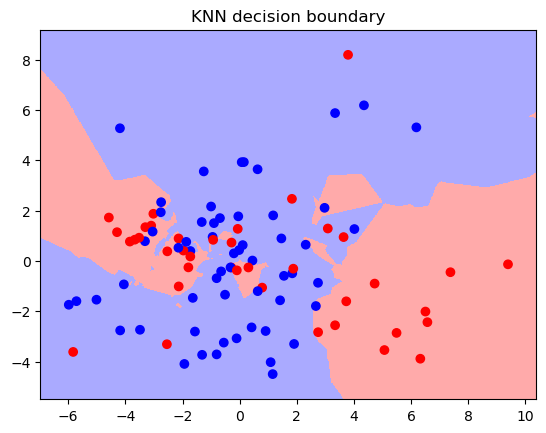

Decision Boundary for SVM classfiier with logmel features


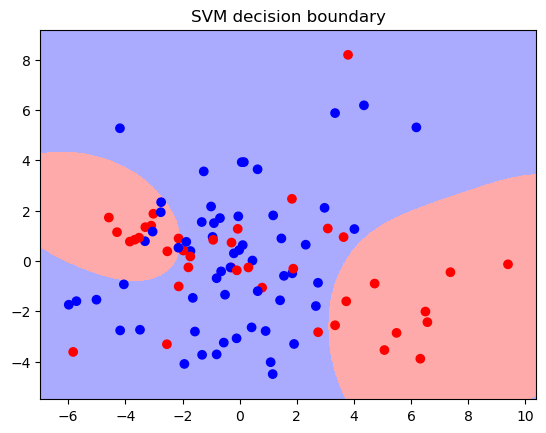


Feature: cqt
0.516667622021522
KNN: 
Accuracy:  0.5555555555555556
Precision:  0.55
Recall:  0.55
SVM: 
Accuracy:  0.16666666666666666
Precision:  0.11538461538461539
Recall:  0.1875
Decision Boundary for kNN classfiier with cqt features, k=5


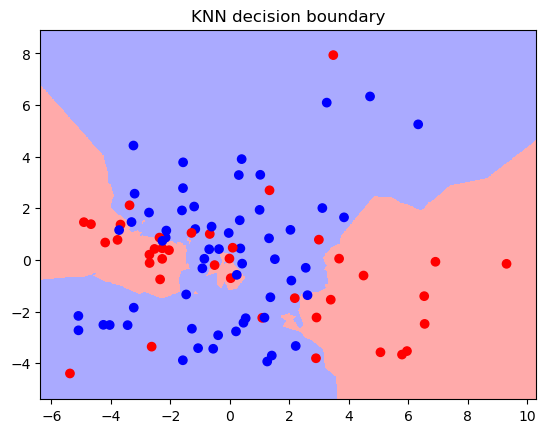

Decision Boundary for SVM classfiier with cqt features


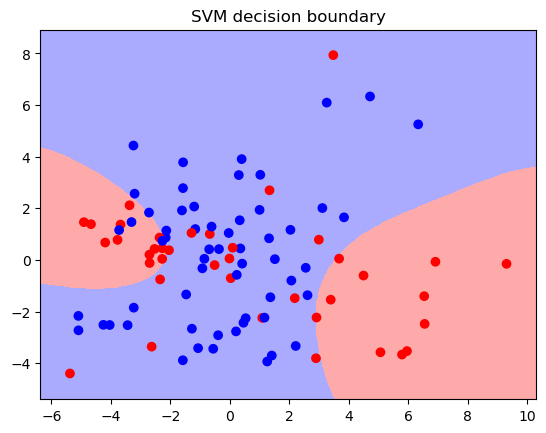

In [17]:
for i in range(len(train_data_list)):
    print("Feature:", feature_names_list[i])

    X, y, X_test, y_test, feature_names, num_class, c2i, i2c = getDataset(
        train_data_list[i], test_data_list[i])

    X_scaled, X_test_scaled, X_pca, X_test_pca = dataPreprocessing(X, X_test)
    # print(feature_names_list[i])
    dataProcessAndTrainAndEvaluate(X_pca, y, feature_names_list[i])
    print()

In [18]:
# Combine the content of the csv files into 1 csv file, keep the fname and real lavel, and combine the predicted label into different columns with the feature name as the column name
# energy_KNN_output.csv, logmel_KNN_output.csv, mel_KNN_output.csv, rms_KNN_output.csv, spec_KNN_output.csv, MFCC_KNN_output.csv, cqt_KNN_output.csv
with open('energy_KNN_output.csv') as f:
    energy_KNN = pd.read_csv(f)
os.remove('energy_KNN_output.csv')
with open('logmel_KNN_output.csv') as f:
    logmel_KNN = pd.read_csv(f)
os.remove('logmel_KNN_output.csv')
with open('mel_KNN_output.csv') as f:
    mel_KNN = pd.read_csv(f)
os.remove('mel_KNN_output.csv')
with open('rms_KNN_output.csv') as f:
    rms_KNN = pd.read_csv(f)
os.remove('rms_KNN_output.csv')
with open('spec_KNN_output.csv') as f:
    spec_KNN = pd.read_csv(f)
os.remove('spec_KNN_output.csv')
with open('MFCC_KNN_output.csv') as f:
    MFCC_KNN = pd.read_csv(f)
os.remove('MFCC_KNN_output.csv')
with open('cqt_KNN_output.csv') as f:
    cqt_KNN = pd.read_csv(f)
os.remove('cqt_KNN_output.csv')

energy_KNN.rename(columns={'y_pred': 'energy'}, inplace=True)
logmel_KNN.rename(columns={'y_pred': 'logmel'}, inplace=True)
mel_KNN.rename(columns={'y_pred': 'mel'}, inplace=True)
rms_KNN.rename(columns={'y_pred': 'rms'}, inplace=True)
spec_KNN.rename(columns={'y_pred': 'spec'}, inplace=True)
MFCC_KNN.rename(columns={'y_pred': 'MFCC'}, inplace=True)
cqt_KNN.rename(columns={'y_pred': 'cqt'}, inplace=True)

# Concatenate the dataframes, deleting the duplicate columns
KNN_concat = pd.concat([energy_KNN, logmel_KNN, mel_KNN, rms_KNN, spec_KNN, MFCC_KNN, cqt_KNN], axis=1)
KNN_concat = KNN_concat.loc[:,~KNN_concat.columns.duplicated()]
print(KNN_concat)

# energy_SVM_output.csv, logmel_SVM_output.csv, mel_SVM_output.csv, rms_SVM_output.csv, spec_SVM_output.csv, MFCC_SVM_output.csv, cqt_SVM_output.csv
with open('energy_SVM_output.csv') as f:
    energy_SVM = pd.read_csv(f)
os.remove('energy_SVM_output.csv')

with open('logmel_SVM_output.csv') as f:
    logmel_SVM = pd.read_csv(f)
os.remove('logmel_SVM_output.csv')

with open('mel_SVM_output.csv') as f:
    mel_SVM = pd.read_csv(f)
os.remove('mel_SVM_output.csv')

with open('rms_SVM_output.csv') as f:
    rms_SVM = pd.read_csv(f)
os.remove('rms_SVM_output.csv')

with open('spec_SVM_output.csv') as f:
    spec_SVM = pd.read_csv(f)
os.remove('spec_SVM_output.csv')

with open('MFCC_SVM_output.csv') as f:
    MFCC_SVM = pd.read_csv(f)
os.remove('MFCC_SVM_output.csv')

with open('cqt_SVM_output.csv') as f:
    cqt_SVM = pd.read_csv(f)
os.remove('cqt_SVM_output.csv')

energy_SVM.rename(columns={'y_pred': 'energy'}, inplace=True)
logmel_SVM.rename(columns={'y_pred': 'logmel'}, inplace=True)
mel_SVM.rename(columns={'y_pred': 'mel'}, inplace=True)
rms_SVM.rename(columns={'y_pred': 'rms'}, inplace=True)
spec_SVM.rename(columns={'y_pred': 'spec'}, inplace=True)
MFCC_SVM.rename(columns={'y_pred': 'MFCC'}, inplace=True)
cqt_SVM.rename(columns={'y_pred': 'cqt'}, inplace=True)

# Concatenate the dataframes, deleting the duplicate columns
SVM_concat = pd.concat([energy_SVM, logmel_SVM, mel_SVM, rms_SVM, spec_SVM, MFCC_SVM, cqt_SVM], axis=1)
SVM_concat = SVM_concat.loc[:,~SVM_concat.columns.duplicated()]
# print(SVM_concat)

         fname energy y_test logmel   mel   rms  spec  MFCC   cqt
0    Bus_1.wav    bus    bus   tram   bus   bus   bus   bus  tram
1   Bus_10.wav    bus    bus   tram   bus   bus   bus   bus  tram
2    Bus_2.wav   tram    bus   tram  tram  tram  tram   bus  tram
3    Bus_3.wav   tram    bus   tram  tram  tram  tram   bus   bus
4    Bus_4.wav   tram    bus   tram  tram  tram  tram   bus   bus
5    Bus_5.wav    bus    bus    bus   bus   bus   bus   bus   bus
6    Bus_6.wav    bus    bus    bus   bus   bus   bus   bus   bus
7    Bus_7.wav   tram    bus   tram  tram  tram  tram   bus   bus
8    Bus_8.wav   tram    bus   tram  tram  tram  tram   bus  tram
9    Bus_9.wav   tram    bus   tram  tram  tram  tram   bus   bus
10  Tram_1.wav   tram   tram   tram  tram  tram  tram  tram  tram
11  Tram_2.wav   tram   tram    bus  tram  tram  tram  tram   bus
12  Tram_3.wav   tram   tram    bus  tram  tram  tram  tram   bus
13  Tram_4.wav   tram   tram    bus  tram  tram  tram  tram  tram
14  Tram_5

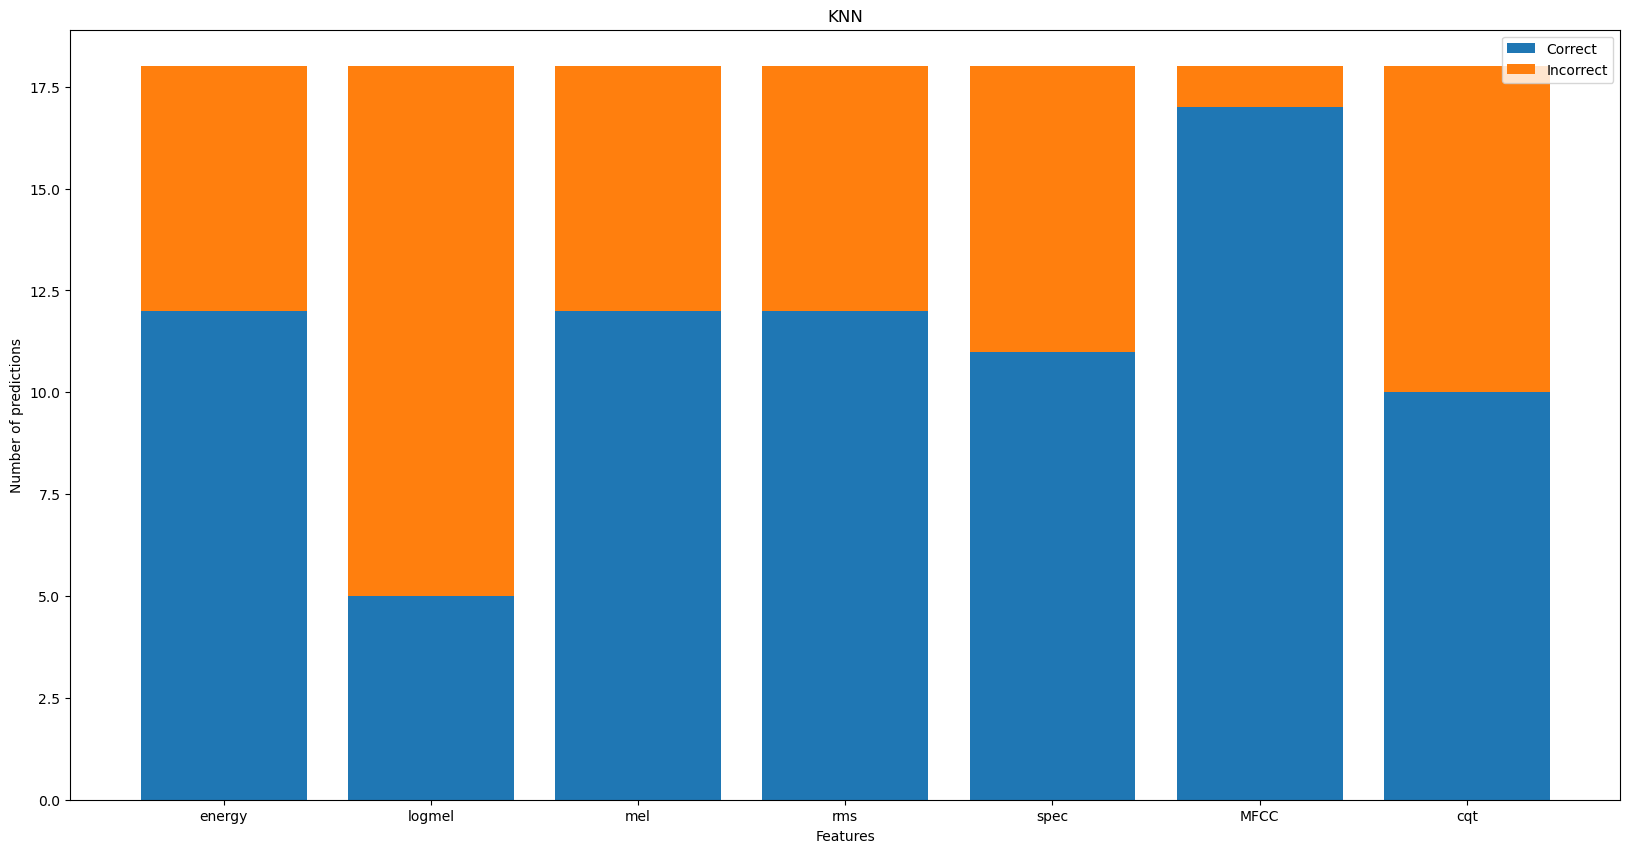

In [19]:
# Print the histogram, counting the number of correct predictions and incorrect predictions for each feature by comparing the predicted label which has been changed by the name and the real label
# KNN
# Calculate the number of correct predictions and incorrect predictions for each feature
energy_KNN_correct = 0
energy_KNN_incorrect = 0
logmel_KNN_correct = 0
logmel_KNN_incorrect = 0
mel_KNN_correct = 0
mel_KNN_incorrect = 0
rms_KNN_correct = 0
rms_KNN_incorrect = 0
spec_KNN_correct = 0
spec_KNN_incorrect = 0
MFCC_KNN_correct = 0
MFCC_KNN_incorrect = 0
cqt_KNN_correct = 0
cqt_KNN_incorrect = 0

for i in range(len(KNN_concat)):
    if KNN_concat['energy'][i] == KNN_concat['y_test'][i]:
        energy_KNN_correct += 1
    else:
        energy_KNN_incorrect += 1
    if KNN_concat['logmel'][i] == KNN_concat['y_test'][i]:
        logmel_KNN_correct += 1
    else:
        logmel_KNN_incorrect += 1
    if KNN_concat['mel'][i] == KNN_concat['y_test'][i]:
        mel_KNN_correct += 1
    else:
        mel_KNN_incorrect += 1
    if KNN_concat['rms'][i] == KNN_concat['y_test'][i]:
        rms_KNN_correct += 1
    else:
        rms_KNN_incorrect += 1
    if KNN_concat['spec'][i] == KNN_concat['y_test'][i]:
        spec_KNN_correct += 1
    else:
        spec_KNN_incorrect += 1
    if KNN_concat['MFCC'][i] == KNN_concat['y_test'][i]:
        MFCC_KNN_correct += 1
    else:
        MFCC_KNN_incorrect += 1
    if KNN_concat['cqt'][i] == KNN_concat['y_test'][i]:
        cqt_KNN_correct += 1
    else:
        cqt_KNN_incorrect += 1
# add to feature_names_list MFCC before cqt
feature_names_list = ["energy", "logmel", "mel", "rms", "spec", "MFCC", "cqt"]
# Plot the diagram with the number of correct predictions and incorrect predictions for each feature
plt.figure(figsize=(20,10))
plt.bar(feature_names_list, [energy_KNN_correct, logmel_KNN_correct, mel_KNN_correct, rms_KNN_correct, spec_KNN_correct, MFCC_KNN_correct, cqt_KNN_correct], label="Correct")
plt.bar(feature_names_list, [energy_KNN_incorrect, logmel_KNN_incorrect, mel_KNN_incorrect, rms_KNN_incorrect, spec_KNN_incorrect, MFCC_KNN_incorrect, cqt_KNN_incorrect], bottom=[energy_KNN_correct, logmel_KNN_correct, mel_KNN_correct, rms_KNN_correct, spec_KNN_correct, MFCC_KNN_correct, cqt_KNN_correct], label="Incorrect")

plt.legend()
plt.xticks(range(len(feature_names_list)), feature_names_list)
plt.xlabel("Features")
plt.ylabel("Number of predictions")
plt.title("KNN")
plt.savefig("KNN.png")
plt.show()

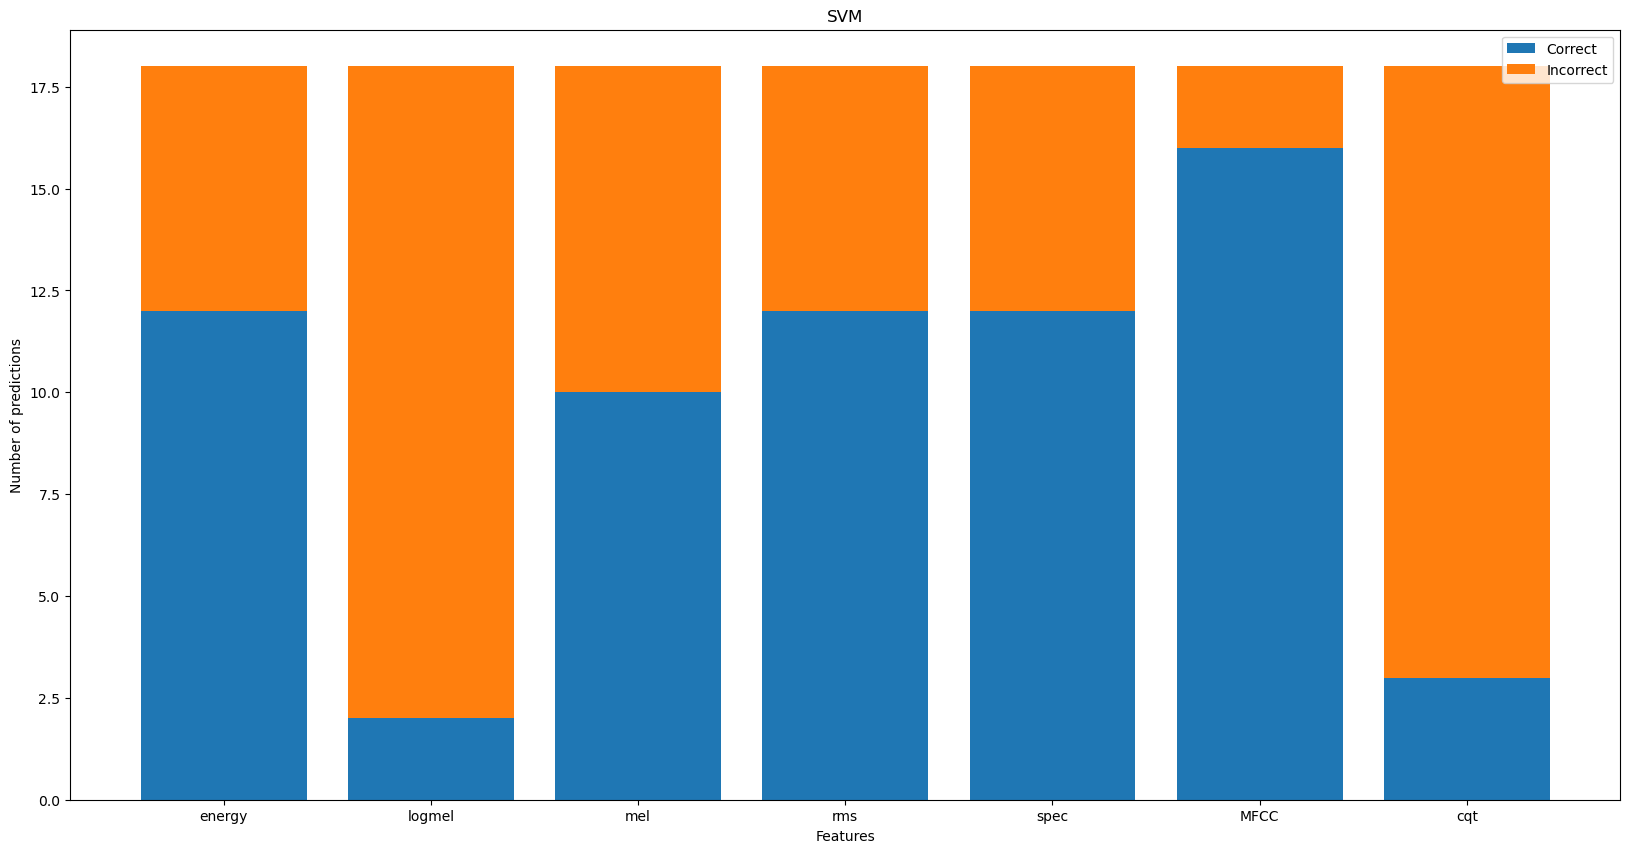

In [20]:
# SVM
# Calculate the number of correct predictions and incorrect predictions for each feature
energy_SVM_correct = 0
energy_SVM_incorrect = 0
logmel_SVM_correct = 0
logmel_SVM_incorrect = 0
mel_SVM_correct = 0
mel_SVM_incorrect = 0
rms_SVM_correct = 0
rms_SVM_incorrect = 0
spec_SVM_correct = 0
spec_SVM_incorrect = 0
MFCC_SVM_correct = 0
MFCC_SVM_incorrect = 0
cqt_SVM_correct = 0
cqt_SVM_incorrect = 0

for i in range(len(SVM_concat)):
    if SVM_concat['energy'][i] == SVM_concat['y_test'][i]:
        energy_SVM_correct += 1
    else:
        energy_SVM_incorrect += 1
    if SVM_concat['logmel'][i] == SVM_concat['y_test'][i]:
        logmel_SVM_correct += 1
    else:
        logmel_SVM_incorrect += 1
    if SVM_concat['mel'][i] == SVM_concat['y_test'][i]:
        mel_SVM_correct += 1
    else:
        mel_SVM_incorrect += 1
    if SVM_concat['rms'][i] == SVM_concat['y_test'][i]:
        rms_SVM_correct += 1
    else:
        rms_SVM_incorrect += 1
    if SVM_concat['spec'][i] == SVM_concat['y_test'][i]:
        spec_SVM_correct += 1
    else:
        spec_SVM_incorrect += 1
    if SVM_concat['MFCC'][i] == SVM_concat['y_test'][i]:
        MFCC_SVM_correct += 1
    else:
        MFCC_SVM_incorrect += 1
    if SVM_concat['cqt'][i] == SVM_concat['y_test'][i]:
        cqt_SVM_correct += 1
    else:
        cqt_SVM_incorrect += 1
    
# Plot the diagram with the number of correct predictions and incorrect predictions for each feature
plt.figure(figsize=(20,10))
plt.bar(feature_names_list, [energy_SVM_correct, logmel_SVM_correct, mel_SVM_correct, rms_SVM_correct, spec_SVM_correct, MFCC_SVM_correct, cqt_SVM_correct], label="Correct")
plt.bar(feature_names_list, [energy_SVM_incorrect, logmel_SVM_incorrect, mel_SVM_incorrect, rms_SVM_incorrect, spec_SVM_incorrect, MFCC_SVM_incorrect, cqt_SVM_incorrect], bottom=[energy_SVM_correct, logmel_SVM_correct, mel_SVM_correct, rms_SVM_correct, spec_SVM_correct, MFCC_SVM_correct, cqt_SVM_correct], label="Incorrect")
plt.xticks(range(len(feature_names_list)), feature_names_list)
plt.legend()
plt.xlabel("Features")
plt.ylabel("Number of predictions")
plt.title("SVM")
plt.savefig("SVM.png")
plt.show()

In [21]:
# export the csv file
KNN_concat.to_csv("KNN_concat.csv", index=False)
SVM_concat.to_csv("SVM_concat.csv", index=False)